In [ ]:
!pip install fairlearn

In [ ]:
from sklearn.model_selection import train_test_split
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.metrics import MetricFrame, selection_rate, count
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as skm
import pandas as pd


In [ ]:
import os
import tempfile
import pandas as pd
import six.moves.urllib as urllib


In [ ]:
_DATA_ROOT = tempfile.mkdtemp(prefix='lsat-data')
_DATA_PATH = 'https://storage.googleapis.com/lawschool_dataset/bar_pass_prediction.csv'

data = urllib.request.urlopen(_DATA_PATH)

lsatdf = pd.read_csv(data)
#filtering the dataset to few a important columns as our main objective is to study fairness
_COLUMN_NAMES = [
  'dnn_bar_pass_prediction',
  'gender',
  'lsat',
  'pass_bar',
  'race1',
  'ugpa',
]

lsatdf['gender'] = lsatdf['gender'].astype(str)
lsatdf['race1'] = lsatdf['race1'].astype(str)
lsatdf = lsatdf[_COLUMN_NAMES]

# encoding male as 1 and female as 0
lsatdf['gender'].replace({'female': 0, 'male':1}, inplace=True)

# converting regression type to classification by taking all values above threshold(3) as 1 else 0
lsatdf['ugpa']=lsatdf['ugpa']>3
lsatdf['ugpa'].replace({True: 1, False:0}, inplace=True)

# one-hot encoding race feature
lsatdf=pd.get_dummies(lsatdf,columns=['race1'])
# Removing NAN values
lsatdf=lsatdf.dropna()

lsatdf=lsatdf[['dnn_bar_pass_prediction',
 'gender',
 'lsat',
 'pass_bar',
 'race1_asian',
 'race1_black',
 'race1_hisp',
 'race1_nan',
 'race1_other',
 'race1_white','ugpa']]
lsatdf=lsatdf[lsatdf['gender']!='nan']
lsatdf.reset_index(inplace = True)
lsatdf=lsatdf.drop(['index'], axis=1)

#Normalizing the features
from sklearn.preprocessing import StandardScaler
cols = ['dnn_bar_pass_prediction','lsat','pass_bar','race1_asian','race1_black','race1_hisp','race1_nan','race1_other','race1_white']

scaler = StandardScaler().fit(lsatdf[cols].values)
features = scaler.transform(lsatdf[cols].values)
lsatdf[cols] = features

In [ ]:
X = lsatdf.iloc[:, 0:-1]
y = lsatdf.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)


In [ ]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)


In [ ]:
unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)

unmitigated_predictor.fit(X_train, y_train)


LogisticRegression(solver='liblinear')

accuracy          0.795617
selection_rate    0.784932
count                 7393
dtype: object
        accuracy selection_rate count
gender                               
0       0.807444       0.879729  3251
1       0.786335       0.710526  4142


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0d56aab10>],
      dtype=object)

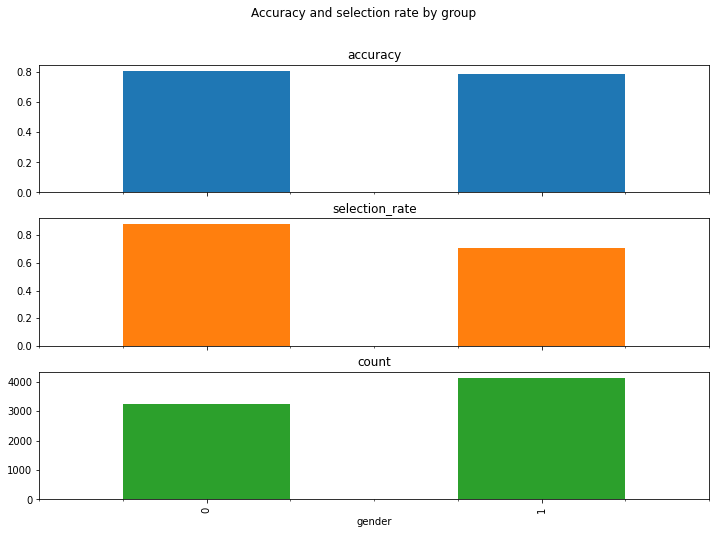

In [ ]:
metric_frame = MetricFrame(metrics={"accuracy": skm.accuracy_score,
                                    "selection_rate": selection_rate,
                                    "count": count},
                           sensitive_features=X_test['gender'],
                           y_true=y_test,
                           y_pred=unmitigated_predictor.predict(X_test))
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
        subplots=True, layout=[3, 1], legend=False, figsize=[12, 8],
        title='Accuracy and selection rate by group')


In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate, count,equalized_odds_difference,demographic_parity_difference

In [ ]:
  bias=demographic_parity_difference(
            y_true=y_test,
            y_pred=unmitigated_predictor.predict(X_test),
            sensitive_features=X_test['gender'],
        )


In [ ]:
bias

0.16920299826773955

In [ ]:
sweep = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                   constraints=DemographicParity(),
                   grid_size=71)


In [ ]:
sweep.fit(X_train, y_train,
          sensitive_features=X_train['gender'])

predictors = sweep.predictors_


/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use g

In [ ]:
errors, disparities = [], []
for m in predictors:
    def classifier(X): return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(y_train), sensitive_features=X_train['gender'])
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(y_train), sensitive_features=X_train['gender'])

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][all_results["disparity"] <= row.disparity]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)


dominant_model_0 0.03405147708516232
dominant_model_1 0.022587708777643156
dominant_model_2 0.07224156115245006


Text(0, 0.5, 'selection rate difference')

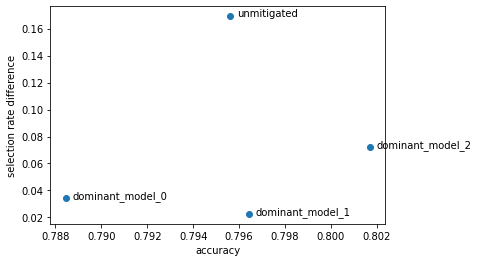

In [ ]:
predictions = {"unmitigated": unmitigated_predictor.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)
    print(key,demographic_parity_difference(
            y_true=y_test,
            y_pred=predictions[key],
            sensitive_features=X_test['gender'],
        )
)
    metric_frames[key] = MetricFrame(metrics={"accuracy": skm.accuracy_score,
                                              "selection_rate": selection_rate,
                                              "count": count},
                                     sensitive_features=X_test['gender'],
                                     y_true=y_test,
                                     y_pred=predictions[key])

import matplotlib.pyplot as plt
x = [metric_frame.overall['accuracy'] for metric_frame in metric_frames.values()]
y = [metric_frame.difference()['selection_rate'] for metric_frame in metric_frames.values()]
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")
